In [2]:
import sympy as sp
import operator
from functools import partial, reduce
from lbmpy.chapman_enskog_old import combineDerivatives, expandDerivatives, getDiffOperator, commuteTerms

# Using operator and kets from quantum module to represent differential operators and pdfs
from  sympy.physics.quantum import Ket as Func
from  sympy.physics.quantum import Operator
# Disable Ket notation |f> for functions
Func.lbracket_latex =''
Func.rbracket_latex = ''

import operator
def prod(factors):
    return reduce(operator.mul, factors, 1)

sp.init_printing()

In [3]:
dim = 2
dimLabels = ['0', '1', '2'][:dim]
# same in 3D
# dimLabels = ['x', 'y', 'z']
dim = len(dimLabels)

# Chapman Enskog analysis

Particle distribution function $f$:

In [4]:
c = sp.Matrix([sp.Symbol(f"c_{label}") for label in dimLabels])
dt = sp.Symbol("Delta_t")
t = sp.symbols("t")
f = Func("f")
C = Func("C")

Differential operators (defined simply as non-commutative symbols here)

In [5]:
Dt = Operator("\partial_t")
Dx = sp.Matrix([Operator(f"\partial_{label}") for label in dimLabels])

In [6]:
dt.sort_key()[0]

(2, 0, 'Symbol')

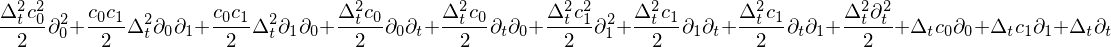

In [7]:
taylorOrder = 2
taylorOperator = sum(dt**k * (Dt + c.dot(Dx) )**k / sp.functions.factorial(k)
                     for k in range(1, taylorOrder+1))
taylorOperator.expand()

As right-hand-side we use the abstract collision operator $C$, which corresponds to (4.5)

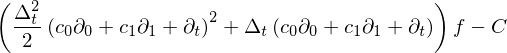

In [8]:
eq_4_5 = (taylorOperator * f) - C
eq_4_5

Following the same steps as in the book, getting rid of second derivative, and discarding $\Delta_t^3$ we get to (4.7)

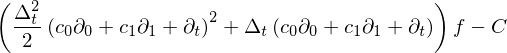

In [9]:
eq_4_5

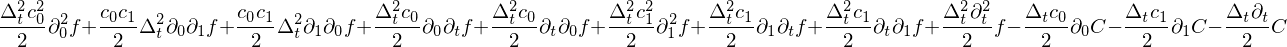

In [10]:
((dt/2)* (Dt + c.dot(Dx) ) * eq_4_5 ).expand().subs(dt**3, 0)

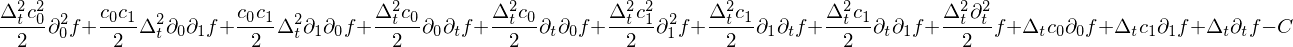

In [11]:
eq_4_5.expand().subs(dt**3, 0)

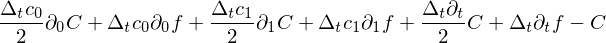

In [12]:
eq_4_7 = eq_4_5 - (dt/2)* (Dt + c.dot(Dx) ) * eq_4_5
eq_4_7 = eq_4_7.expand().subs(dt**3, 0)
eq_4_7

### Chapman Enskog Ansatz

Open Question:
 why is not everything expanded equally (derivatives start at 1, spatial terminates one earlier...)

In [13]:
f.args[0].func

sympy.core.symbol.Symbol

In [14]:
def getName(obj):
    if type(obj) in [Operator, Func]:
        return obj.args[0].name
    else:
        return obj.name


def getExpandedName(originalObject, number):
    """Takes an object (Symbol, Function, Operator) and an index number and returns an object of the same type
    with a name, that has as superscript the index in brackets"""
    name = getName(originalObject)
    
    if '_' in name:
        newName = name + "^{(%i)}" % (number,)
    else:
        newName = name + "_{%i}" % (number,)
    return originalObject.func(newName)


def getExpanded(originalObject, fromOrder=0, toOrder=2, indexStart=None, variable=sp.Symbol("epsilon")):       
    if type(originalObject) == sp.Matrix:
        return originalObject.applyfunc(partial(getExpanded, fromOrder=fromOrder, toOrder=toOrder, 
                                                indexStart=indexStart, variable=variable))
        
    if indexStart is None:
        indexStart = fromOrder
    
    result = 0
    for i in range(fromOrder, toOrder+1):
        result += variable ** i * getExpandedName(originalObject, indexStart)
        indexStart += 1
        
    return result

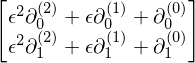

In [15]:
getExpanded(Dx)

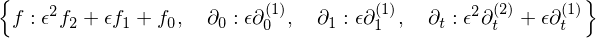

In [16]:
eps = sp.Symbol("epsilon")

ceF  =  getExpanded(f)
ceDt = getExpanded(Dt,  fromOrder=1)
ceDx = getExpanded(Dx, fromOrder=1, toOrder=1)

ceSubstitutions = {
    Dt : ceDt,
    f: ceF
}
ceSubstitutions.update({a: b for a, b in zip(Dx, ceDx)})
ceSubstitutions

Inserting the SRT/BGK collision operator

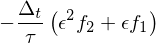

In [17]:
srtC = -dt / sp.Symbol("tau") * ( ceF - getExpandedName(f,0))
srtC

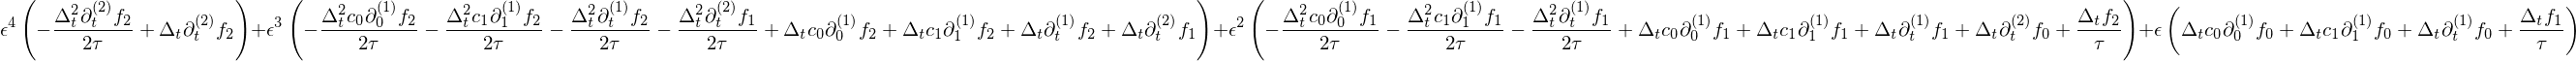

In [18]:
eq_4_7_ce = eq_4_7.subs(ceSubstitutions).subs(C, srtC).expand().collect(eps)
eq_4_7_ce

$ \mathcal{O}(\epsilon) $:

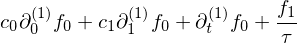

In [19]:
eq_4_9_a = (eq_4_7_ce.coeff(eps) / dt).expand()
eq_4_9_a

$ \mathcal{O}(\epsilon^2) $:

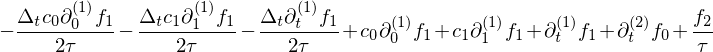

In [20]:
eq_4_9_b = (eq_4_7_ce.coeff(eps**2) / dt).expand()
eq_4_9_b

Computing moments

In [21]:
def getMomentFuncFromCIndices(cIndices, approxOrder):
    cLabels = sorted([dimLabels[i] for i in cIndices])
    cLabels = sorted([dimLabels[i] for i in cIndices])
    resultObject = Func("\Pi^{(%d)}_{%s}" % (approxOrder, "".join(cLabels)))
    momentTuple = [0] * len(dimLabels)
    for i in range(len(dimLabels)):
        momentTuple[i] = cIndices.count(i)
    
    resultObject.momentTuple = tuple(momentTuple)
    resultObject.approxOrder = approxOrder
    return resultObject

def getMomentFunc(cProduct, approxOrder):
    cIndices = []
    velTerms = list(c)
    for factor, power in cProduct.as_powers_dict().items():
        assert factor in velTerms
        cIndices += [velTerms.index(factor)] * power
    return getMomentFuncFromCIndices(cIndices, approxOrder)

def parseMomentFunc(func):
    if hasattr(func, 'momentTuple'):
        return func.momentTuple, func.approxOrder
    
def takeMoments(eqn, pdfExpansionTerms, velocityTerms): 
    def handleProduct(productTerm):
        assert productTerm.func == sp.Mul
        
        fIndices = []
        cIndices = []
        rest = 1
        for factor, power in productTerm.as_powers_dict().items():
            if factor in pdfExpansionTerms:
                fIndices += [pdfExpansionTerms.index(factor)] * power
            elif factor in velocityTerms:
                cIndices += [velocityTerms.index(factor)] * power
            else:
                rest *= factor ** power           
        if len(fIndices) != 1:
            raise ValueError("Cannot take moment of term " + str(productTerm) + ". Term has to contain exactly one pdf")
        cLabels = sorted([dimLabels[i] for i in cIndices])
        
        
        # TODO make this more explicit by passing in a dict, that contains conserved moment names / values
        if len(cLabels) <= 1 and fIndices[0] > 0: # Conserved moments of f_(neq) are zero
            return 0
        
        #return rest * Func("\Pi^{(%d)}_{%s}" % (fIndices[0], "".join(cLabels)))
    
        if len(cLabels) == 0:
            return rest * Func("rho")
        elif len(cLabels) == 1:
            return rest * Func("rho") * Func("u_%s" % (cLabels[0],))
        elif len(cLabels) >= 2:
            momSym = getMomentFuncFromCIndices(cIndices, fIndices[0])
            return rest * momSym
    
    eqn = eqn.expand()

    if eqn.func == sp.Mul:
        return handleProduct(eqn)
    else:
        assert eqn.func == sp.Add
        return sum(handleProduct(t) for t in eqn.args)

In [22]:
expFs = sorted(list(ceF.atoms(Func)), key=getName)

def tm(eq):
    return takeMoments(eq, expFs, list(c))

### Moments

Moments of $\epsilon$-sorted equations

$O(\epsilon)$

In [23]:
eq_4_10_a = tm(eq_4_9_a)
eq_4_10_a

In [24]:
eq_4_10_b = tm(eq_4_9_a * c[0])
eq_4_10_b

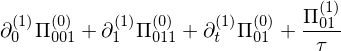

In [25]:
eq_4_10_c = tm(eq_4_9_a * c[0] * c[1])
eq_4_10_c

$O(\epsilon^2)$

In [26]:
eq_4_12_a = tm(eq_4_9_b)
eq_4_12_a

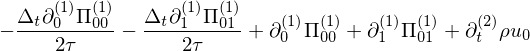

In [27]:
eq_4_12_b = tm(eq_4_9_b * c[0])
eq_4_12_b

Recombination

In [28]:
(eps * eq_4_10_a + eps**2 * eq_4_12_a).expand()

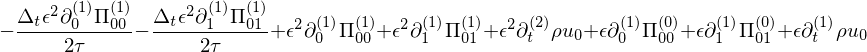

In [29]:
(eps * eq_4_10_b + eps**2 * eq_4_12_b).expand()

### Moments $\Pi^{(1)}_{\alpha\beta}$

- results should have all time derivatives replaced by spatial derivatives
- input equations: (4.10 a-c)
    - for moment of second order, the input equation is the second moment of the $O(\epsilon)$  equation, which has 
      the relevant moment on the rhs
    - additionally the lower order moments of the same equation are used as well

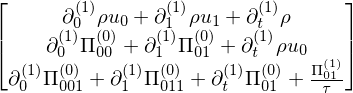

In [30]:
sp.Matrix([tm(eq_4_9_a),  tm(eq_4_9_a * c[0]), tm(eq_4_9_a * c[0] * c[1]) ])

In [31]:
def momentSymbolsToFunc(expr):
    subsDict = {sym: Func(sym.name)  for sym in expr.atoms(sp.Symbol)}
    return expr.subs(subsDict)

def momentGetterD2Q9(momentTuple):
    from lbmpy.moments import discreteMoment
    from lbmpy.creationfunctions import createLatticeBoltzmannMethod
    from lbmpy.stencils import getStencil
    stencilName = "D2Q9"
    method = createLatticeBoltzmannMethod(stencil=stencilName, compressible=True, equilibriumAccuracyOrder=2)
    eq = method.getEquilibrium()
    eq = tuple(e.rhs for e in eq.mainEquations)
    return momentSymbolsToFunc(discreteMoment(eq, momentTuple, getStencil(stencilName)))

def replaceEquilibriumMoments(eq, momentGetter):
    subsDict = {}
    for func in eq.atoms(Func):
        mom = parseMomentFunc(func)
        if mom:
            momentTuple, approxOrder = mom
            if approxOrder == 0:
                subsDict[func] = momentGetter(momentTuple)
    return eq.subs(subsDict)

def getSecondOrderMomentEq(oEpsEq, cProduct):
    solveResult = sp.solve( tm(oEpsEq * cProduct), getMomentFunc(cProduct, 1) )
    assert len(solveResult) == 1, "Could not solve for required moment"
    momEq = solveResult[0]
    return momEq

def solveWithWorkaround(equation, termToSolveFor):
    dummy = sp.Dummy()
    equation = equation.subs(termToSolveFor, dummy)
    rest = None
    for term in equation.expand().args:
        if dummy in term.atoms(sp.Symbol):
            rest = term / dummy
            break
    assert rest is not None
    #print("Rest", rest)
    equation = ((1/rest) * equation).expand()
    #return equation
    return sp.solve_linear(equation, symbols=[dummy])[1]

## Derivation of second (higher order) moment as in A.2

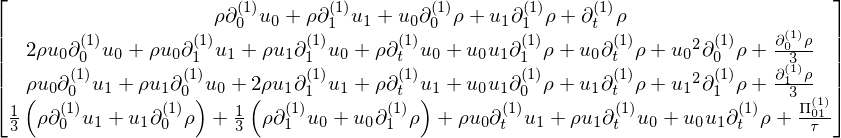

In [32]:
eqs = [expandDerivatives(replaceEquilibriumMoments(tm(eq_4_9_a * cs), momentGetterD2Q9))
       for cs in [sp.Rational(1,1),  c[0], c[1],  c[0] * c[1] ] ]
sp.Matrix(eqs)

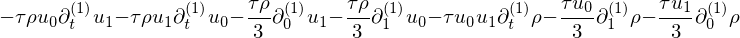

In [33]:
secondOrderMomentEq = getSecondOrderMomentEq(eq_4_9_a, c[0] * c[1])
secondOrderMomentEq = replaceEquilibriumMoments(secondOrderMomentEq, momentGetterD2Q9).expand()
secondOrderMomentEq = expandDerivatives(secondOrderMomentEq).expand()
secondOrderMomentEq

Time derivatives have to be replaced with information from lower order moments

In [34]:
rhoDeriv = getDiffOperator("t", "{(1)}") * Func("rho")
rhoSolveRes = solveWithWorkaround(eqs[0],rhoDeriv)
rhoSolveRes

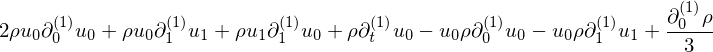

In [35]:
eqs[1] = eqs[1].subs(rhoDeriv, rhoSolveRes).expand()
eqs[1]

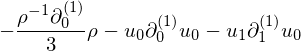

In [36]:
from pystencils.display_utils import toDot
u0Div = getDiffOperator("t", "{(1)}") * Func("u_0")
u0SolveRes = solveWithWorkaround(eqs[1], u0Div).subs(rhoDeriv, rhoSolveRes).expand()
u0SolveRes = commuteTerms(u0SolveRes)
u0SolveRes
#testTerm = u0SolveRes.args[3]
#toDot(testTerm)

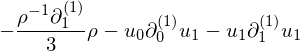

In [37]:
u1Div = getDiffOperator("t", "{(1)}") * Func("u_1")
u1SolveRes = solveWithWorkaround(eqs[2], u1Div).subs(rhoDeriv, rhoSolveRes).expand()
u1SolveRes = commuteTerms(u1SolveRes)
u1SolveRes

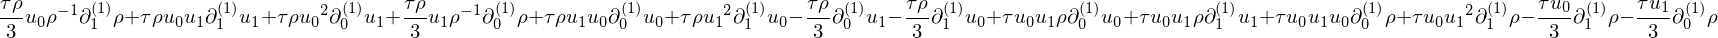

In [38]:
subsDict = {rhoDeriv: rhoSolveRes,
            u0Div: u0SolveRes, 
            u1Div: u1SolveRes}
res = secondOrderMomentEq.subs(subsDict).expand()
res

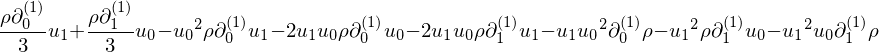

In [39]:
res = (commuteTerms(res) / (-sp.Symbol("tau") )).expand()
result = commuteTerms(res)
result

In [40]:
combineDerivatives(combineDerivatives(commuteTerms(res)))